## Vilhelmsen LGR

These are the models described in Vilhelmsen et al. (2012).  The parent
model is 9 layers, the child model is 25 layers.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import flopy.utils.lgrutil
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-lgrv"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "seconds"

# Scenario-specific parameters
parameters = {
    "ex-gwf-lgrv-gr": {"configuration": "Refined"},
    "ex-gwf-lgrv-gc": {"configuration": "Coarse"},
    "ex-gwf-lgrv-lgr": {"configuration": "LGR"},
}

# Model parameters
nper = 1  # Number of periods
nlay = 25  # Number of layers in refined model
nrow = 183  # Number of rows in refined model
ncol = 147  # Number of columns in refined model
nlaygc = 9  # Number of layers in coarsened model
nrowcg = 61  # Number of rows in coarsened model
ncolcg = 49  # Number of columns in coarsened model
delr = 35.0  # Column width ($m$) in refined model
delc = 25.0  # Row width ($m$) in refined model
delv = 5.0  # Layer thickness ($m$) in refined model
delrgc = 105.0  # Column width ($m$) in coarsened model
delcgc = 75.0  # Row width ($m$) in coarsened model
delvgc = 15.0  # Layer thickness ($m$) in coarsened model
top_str = "variable"  # Top of the model ($m$)
botm_str = "30 to -90"  # Layer bottom elevations ($m$)
icelltype = 0  # Cell conversion type
recharge = 1.1098e-09  # Recharge rate ($m/s$)
k11_str = "5.e-07, 1.e-06, 5.e-05"  # Horizontal hydraulic conductivity ($m/s$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
perlen = [1.0]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# load data files and process into arrays
fname = "top.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:7e95923e78d0a2e2133929376d913ecf",
)
top = np.loadtxt(fpath)
ikzone = np.empty((nlay, nrow, ncol), dtype=float)
hashes = [
    "548876af515cb8db0c17e7cba0cda364",
    "548876af515cb8db0c17e7cba0cda364",
    "548876af515cb8db0c17e7cba0cda364",
    "548876af515cb8db0c17e7cba0cda364",
    "d91e2663ad671119de17a91ffb2a65ab",
    "1702d97a83074669db86521b22b87304",
    "da973a8edd77a44ed23a29661e2935eb",
    "0d514a8f7b208e840a8e5cbfe4018c63",
    "afd45ac7125f8351b73add34d35d8435",
    "dc99e101996376e1dde1d172dea05f5d",
    "fe8d2de0558245c9270597b01070403a",
    "cd1fcf0fe2c807ff53eda80860bfe50f",
    "c77b43c8045f5459a75547d575665134",
    "2252b57927d7d01d0f9a0dda262397d7",
    "1399c6872dd7c41be4b10c1251ad7c65",
    "331e4006370cceb3864b881b7a0558d6",
    "a46e66e632c5af7bf104900793509e5d",
    "41f44eee3db48234069de4e9e329317b",
    "8f4f1bdd6b6863c3ba68e2336f5ff70a",
    "a1c856c05bcc4a17cf3fe61b87fbc720",
    "a23fef9e866ad9763943150a3b70f5eb",
    "02d67bc7f67814d2248c27cdd5205cf8",
    "e7a07da76d111ef2229d26c553daa7eb",
    "f6bc51735c4af81e1298d0efd06cd506",
    "432b9a02f3ff4906a214b271c965ebad",
]
for k in range(nlay):
    fname = f"ikzone{k + 1}.dat"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash=f"md5:{hashes[k]}",
    )
    ikzone[k, :, :] = np.loadtxt(fpath)
fname = "riv.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:5ccbe4f29940376309db445dbb2d75d0",
)
dt = [
    ("k", int),
    ("i", int),
    ("j", int),
    ("stage", float),
    ("conductance", float),
    ("rbot", float),
]
rivdat = np.loadtxt(fpath, dtype=dt)
rivdat["k"] -= 1
rivdat["i"] -= 1
rivdat["j"] -= 1
riv_spd = [[(k, i, j), stage, cond, rbot] for k, i, j, stage, cond, rbot in rivdat]

botm = [30 - k * delv for k in range(nlay)]
botm = np.array(botm)
k11_values = [float(value) for value in k11_str.split(",")]
k11 = np.zeros((nlay, nrow, ncol), dtype=float)
for i, kval in enumerate(k11_values):
    k11 = np.where(ikzone == i + 1, kval, k11)

# Define model extent and child model extent
xmin = 0
xmax = ncol * delr
ymin = 0.0
ymax = nrow * delc
model_domain = [xmin, xmax, ymin, ymax]
child_domain = [
    xmin + 15 * 3 * delr,
    xmin + 41 * 3 * delr,
    ymax - 49 * 3 * delc,
    ymax - 19 * 3 * delc,
]

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-6
rclose = 100.0

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def coarsen_shape(icoarsen, nrow, ncol):
    nrowc = int(np.ceil(nrow / icoarsen))
    ncolc = int(np.ceil(ncol / icoarsen))
    return (nrowc, ncolc)


def create_resampling_labels(a, icoarsen):
    nrow, ncol = a.shape
    labels = np.zeros((nrow, ncol), dtype=int)
    nodec = 0
    for ic in range(0, nrow, icoarsen):
        for jc in range(0, ncol, icoarsen):
            labels[ic : ic + icoarsen, jc : jc + icoarsen] = nodec
            nodec += 1
    return labels


def array_resampler(a, icoarsen, method):
    import scipy.ndimage as ndimage

    assert method in ["mean", "minimum", "maximum", "sum"]
    nrow, ncol = a.shape
    nrowc, ncolc = coarsen_shape(icoarsen, nrow, ncol)
    labels = create_resampling_labels(a, icoarsen)
    idx = np.array(range(nrowc * ncolc))
    if method == "mean":
        ar = ndimage.mean(a, labels=labels, index=idx)
    elif method == "minimum":
        ar = ndimage.minimum(a, labels=labels, index=idx)
    elif method == "maximum":
        ar = ndimage.maximum(a, labels=labels, index=idx)
    elif method == "sum":
        ar = ndimage.sum(a, labels=labels, index=idx)
    return ar.reshape((nrowc, ncolc))


def riv_resample(icoarsen, nrow, ncol, rivdat, idomain, rowcolspan):
    stage_grid = np.zeros((nrow, ncol), dtype=float)
    cond_grid = np.zeros((nrow, ncol), dtype=float)
    rbot_grid = np.zeros((nrow, ncol), dtype=float)
    count_grid = np.zeros((nrow, ncol), dtype=int)
    for k, i, j, stage, cond, rbot in rivdat:
        stage_grid[i, j] = stage
        cond_grid[i, j] = cond
        rbot_grid[i, j] = rbot
        count_grid[i, j] += 1
    stagec_grid = array_resampler(stage_grid, icoarsen, "sum")
    condc_grid = array_resampler(cond_grid, icoarsen, "sum")
    rbotc_grid = array_resampler(rbot_grid, icoarsen, "sum")
    countc_grid = array_resampler(count_grid, icoarsen, "sum")
    stagec_grid = np.divide(stagec_grid, countc_grid)
    rbotc_grid = np.divide(rbotc_grid, countc_grid)
    if rowcolspan is not None:
        istart, istop, jstart, jstop = rowcolspan
        stagec_grid = stagec_grid[istart:istop, jstart:jstop]
        condc_grid = condc_grid[istart:istop, jstart:jstop]
        rbotc_grid = rbotc_grid[istart:istop, jstart:jstop]
        countc_grid = countc_grid[istart:istop, jstart:jstop]
    rows, cols = np.where(condc_grid > 0.0)
    rivdatc = []
    for i, j in zip(rows, cols):
        k = 0
        if idomain[k, i, j] == 1:
            rivdatc.append(
                [(k, i, j), stagec_grid[i, j], condc_grid[i, j], rbotc_grid[i, j]]
            )
    return rivdatc


def build_lgr_model(name):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )

    # parent model with coarse grid
    icoarsen = 3
    ncppl = [1, 3, 3, 3, 3, 3, 3, 3, 3]
    sim = build_parent_model(sim, name, icoarsen=icoarsen, ncppl=ncppl)
    gwf = sim.get_model("parent")

    # child model with fine grid
    sim = build_child_model(sim, name)
    gwfc = sim.get_model("child")

    # use flopy lgr utility to wire up connections between parent and child
    nlayp = len(ncppl)
    nrowp = gwf.dis.nrow.get_data()
    ncolp = gwf.dis.ncol.get_data()
    delrp = gwf.dis.delr.array
    delcp = gwf.dis.delc.array
    topp = gwf.dis.top.array
    botmp = gwf.dis.botm.array
    idomainp = gwf.dis.idomain.array
    lgr = flopy.utils.lgrutil.Lgr(
        nlayp,
        nrowp,
        ncolp,
        delrp,
        delcp,
        topp,
        botmp,
        idomainp,
        ncpp=icoarsen,
        ncppl=ncppl,
    )

    # swap out lgr child top and botm with
    topc = gwfc.dis.top.array
    botmc = gwfc.dis.botm.array
    lgr.top = topc
    lgr.botm = botmc
    exgdata = lgr.get_exchange_data(angldegx=True, cdist=True)
    flopy.mf6.ModflowGwfgwf(
        sim,
        nexg=len(exgdata),
        exgtype="GWF6-GWF6",
        exgmnamea="parent",
        exgmnameb="child",
        exchangedata=exgdata,
        auxiliary=["angldegx", "cdist"],
    )

    return sim


def build_parent_model(sim, name, icoarsen, ncppl):
    xminp, xmaxp, yminp, ymaxp = model_domain
    xminc, xmaxc, yminc, ymaxc = child_domain
    delcp = delc * icoarsen
    delrp = delr * icoarsen
    istart = int((ymaxp - ymaxc) / delcp)
    istop = int((ymaxp - yminc) / delcp)
    jstart = int((xminc - xminp) / delrp)
    jstop = int((xmaxc - xminp) / delrp)
    nrowp, ncolp = coarsen_shape(icoarsen, nrow, ncol)
    nlayp = len(ncppl)
    idomain = np.ones((nlayp, nrowp, ncolp), dtype=int)
    idomain[:, istart:istop, jstart:jstop] = 0
    sim = build_models(
        name,
        icoarsen=icoarsen,
        ncppl=ncppl,
        idomain=idomain,
        sim=sim,
        modelname="parent",
    )
    return sim


def build_child_model(sim, name):
    icoarsen = 1
    xminp, xmaxp, yminp, ymaxp = model_domain
    xminc, xmaxc, yminc, ymaxc = child_domain
    delcp = delc * icoarsen
    delrp = delr * icoarsen
    istart = int((ymaxp - ymaxc) / delcp)
    istop = int((ymaxp - yminc) / delcp)
    jstart = int((xminc - xminp) / delrp)
    jstop = int((xmaxc - xminp) / delrp)
    nrowp, ncolp = coarsen_shape(icoarsen, nrow, ncol)
    sim = build_models(
        name,
        rowcolspan=[istart, istop, jstart, jstop],
        sim=sim,
        modelname="child",
        xorigin=xminc,
        yorigin=yminc,
    )
    return sim


def build_models(
    name,
    icoarsen=1,
    ncppl=None,
    rowcolspan=None,
    idomain=None,
    sim=None,
    modelname=None,
    xorigin=None,
    yorigin=None,
):
    if sim is None:
        sim_ws = os.path.join(workspace, name)
        sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
        flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
        flopy.mf6.ModflowIms(
            sim,
            outer_maximum=nouter,
            outer_dvclose=hclose,
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=f"{rclose} strict",
        )
    if modelname is None:
        modelname = name
    gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)

    if ncppl is not None:
        nlayc = len(ncppl)
        layer_index = [ncppl[0] - 1]
        for iln in ncppl[1:]:
            last = layer_index[-1]
            layer_index.append(iln + last)
    else:
        nlayc = nlay
        layer_index = list(range(nlayc))
    nrowc, ncolc = coarsen_shape(icoarsen, nrow, ncol)
    delrc = delr * icoarsen
    delcc = delc * icoarsen
    topc = array_resampler(top, icoarsen, "mean")
    if rowcolspan is not None:
        istart, istop, jstart, jstop = rowcolspan
        nrowc = istop - istart
        ncolc = jstop - jstart
    else:
        istart = 0
        istop = nrow
        jstart = 0
        jstop = ncol
    if idomain is None:
        idomain = 1
    topc = topc[istart:istop, jstart:jstop]
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlayc,
        nrow=nrowc,
        ncol=ncolc,
        delr=delrc,
        delc=delcc,
        top=topc,
        botm=botm[layer_index],
        idomain=idomain,
        xorigin=xorigin,
        yorigin=yorigin,
    )
    idomain = gwf.dis.idomain.array
    k11c = []
    for k in range(nlayc):
        ilay = layer_index[k]
        a = array_resampler(k11[ilay], icoarsen, "maximum")
        k11c.append(a[istart:istop, jstart:jstop])
    flopy.mf6.ModflowGwfnpf(
        gwf,
        k33overk=True,
        icelltype=icelltype,
        k=k11c,
        save_specific_discharge=True,
        k33=1.0,
    )
    strt = nlayc * [topc]
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    rivdatc = riv_resample(icoarsen, nrow, ncol, rivdat, idomain, rowcolspan)
    riv_spd = {0: rivdatc}
    flopy.mf6.ModflowGwfriv(
        gwf,
        stress_period_data=riv_spd,
        pname="RIV",
    )
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge, pname="RCH")
    head_filerecord = f"{modelname}.hds"
    budget_filerecord = f"{modelname}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 4)


def plot_grid(sim):
    with styles.USGSMap():
        name = sim.name
        gwf = sim.get_model("parent")
        gwfc = None
        if "child" in list(sim.model_names):
            gwfc = sim.get_model("child")

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        # pmv.plot_grid()
        idomain = gwf.dis.idomain.array
        tp = np.ma.masked_where(idomain[0] == 0, gwf.dis.top.array)
        vmin = tp.min()
        vmax = tp.max()
        if gwfc is not None:
            tpc = gwfc.dis.top.array
            vmin = min(vmin, tpc.min())
            vmax = max(vmax, tpc.max())

        cb = pmv.plot_array(tp, cmap="jet", alpha=0.25, vmin=vmin, vmax=vmax)
        pmv.plot_bc(name="RIV")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        cbar = plt.colorbar(cb, shrink=0.5)
        cbar.ax.set_xlabel(r"Top, ($m$)")
        if gwfc is not None:
            pmv = flopy.plot.PlotMapView(model=gwfc, ax=ax, layer=0)
            _ = pmv.plot_array(
                tpc, cmap="jet", alpha=0.25, masked_values=[1e30], vmin=vmin, vmax=vmax
            )
            pmv.plot_bc(name="RIV")
        if gwfc is not None:
            xmin, xmax, ymin, ymax = child_domain
            ax.plot(
                [xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], "k--"
            )
        xmin, xmax, ymin, ymax = model_domain
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-grid.png"
            fig.savefig(fpth)


def plot_xsect(sim):
    print(f"Plotting cross section for {sim.name}...")
    with styles.USGSMap():
        name = sim.name
        gwf = sim.get_model("parent")

        fig = plt.figure(figsize=(5, 2.5))
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1)
        irow, icol = gwf.modelgrid.intersect(3000.0, 3000.0)
        pmv = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": icol})
        pmv.plot_grid(linewidth=0.5)
        hyc = np.log(gwf.npf.k.array)
        cb = pmv.plot_array(hyc, cmap="jet", alpha=0.25)
        ax.set_xlabel("y position (m)")
        ax.set_ylabel("z position (m)")
        cbar = plt.colorbar(cb, shrink=0.5)
        cbar.ax.set_xlabel(r"K, ($m/s$)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-xsect.png"
            fig.savefig(fpth)


def plot_heads(sim):
    print(f"Plotting results for {sim.name} ...")
    with styles.USGSMap():
        name = sim.name
        gwf = sim.get_model("parent")
        gwfc = None
        if "child" in list(sim.model_names):
            gwfc = sim.get_model("child")

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        print("  Loading heads...")
        layer = 0
        head = gwf.output.head().get_data()
        head = np.ma.masked_where(head > 1e29, head)
        vmin = head[layer].min()
        vmax = head[layer].max()
        if gwfc is not None:
            headc = gwfc.output.head().get_data()
            vmin = min(vmin, headc.min())
            vmax = max(vmax, headc.max())

        print("  Making figure...")
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        cb = pmv.plot_array(
            head, cmap="jet", masked_values=[1e30], vmin=vmin, vmax=vmax
        )
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        cbar = plt.colorbar(cb, shrink=0.5)
        cbar.ax.set_xlabel(r"Head, ($m$)")
        if gwfc is not None:
            pmv = flopy.plot.PlotMapView(model=gwfc, ax=ax, layer=0)
            cb = pmv.plot_array(
                headc, cmap="jet", masked_values=[1e30], vmin=vmin, vmax=vmax
            )
            xmin, xmax, ymin, ymax = child_domain
            ax.plot(
                [xmin, xmax, xmax, xmin, xmin],
                [ymin, ymin, ymax, ymax, ymin],
                "k--",
            )
        xmin, xmax, ymin, ymax = model_domain
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-head.png"
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    plot_grid(sim)
    plot_xsect(sim)
    plot_heads(sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    if params["configuration"] == "Refined":
        sim = build_models(key, modelname="parent")
    elif params["configuration"] == "Coarse":
        ncppl = [1, 3, 3, 3, 3, 3, 3, 3, 3]
        sim = build_models(key, icoarsen=3, ncppl=ncppl, modelname="parent")
    elif params["configuration"] == "LGR":
        sim = build_lgr_model(key)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)

Run the global refined model and plot results.

run_models took 27446.46 ms


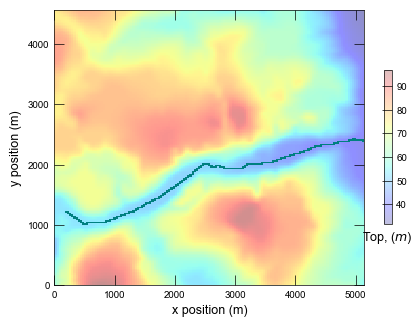

Plotting cross section for ex-gwf-lgrv-gr...


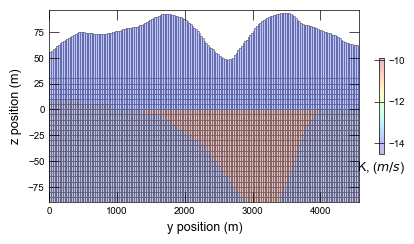

Plotting results for ex-gwf-lgrv-gr ...
  Loading heads...
  Making figure...


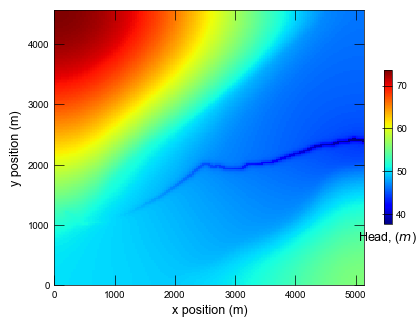

In [6]:
scenario(0)

Run the global coarse model and plot results.

run_models took 290.73 ms


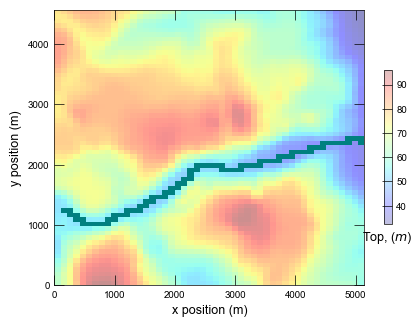

Plotting cross section for ex-gwf-lgrv-gc...


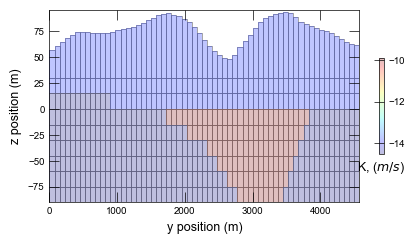

Plotting results for ex-gwf-lgrv-gc ...
  Loading heads...
  Making figure...


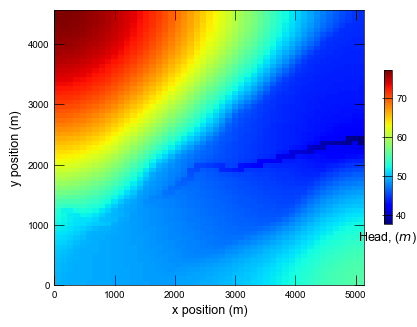

In [7]:
scenario(1)

Run the locally refined grid model and plot results.

run_models took 5902.80 ms


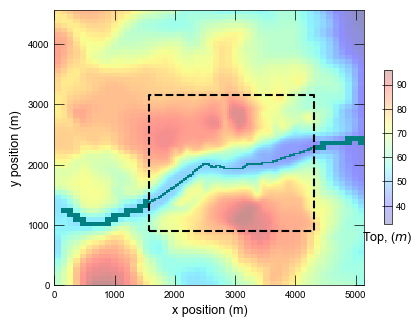

Plotting cross section for ex-gwf-lgrv-lgr...


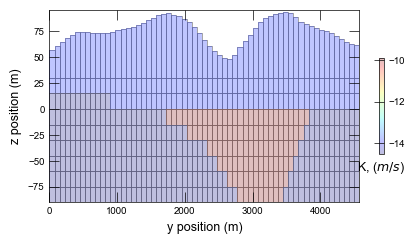

Plotting results for ex-gwf-lgrv-lgr ...
  Loading heads...
  Making figure...


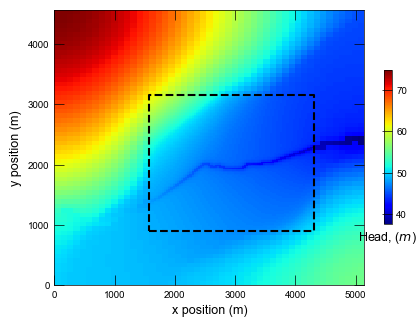

In [8]:
scenario(2)